# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import numpy as np
import speckleret as spr

Load the interferometric data

In [100]:
path = r'R:\Axe-Photonique\Phocal\7531Phocal\partage\Article Siwar\PR\OAMs'
date = '20250716-172641'

CP = np.load(os.path.join(path, 'NF__shaping_frames_' + date + '.npz'))['frames']
CL = np.load(os.path.join(path, 'FF__shaping_frames_' + date + '.npz'))['frames']

print(CP.shape)
print(CL.shape)

(1, 384, 384)
(1, 384, 384)


In [2]:
path = r'C:\Users\saucourt\Downloads'
date = 'datasets_of_CLX_10000_1D_Actu_16_at_20250624-164743'

intens = np.load(os.path.join(path, date + '.npz'))['intens'][500:550, ...]
# CL = np.load(os.path.join(path, date + '.npz'))['frames']

# print(CP.shape)
# print(CL.shape)

In [3]:
CP = intens[..., 0]
CL = intens[..., 1]

print(CP.shape)
print(CL.shape)

(50, 384, 384)
(50, 384, 384)


In [8]:
print(intens.shape)

(10000, 384, 384, 2)


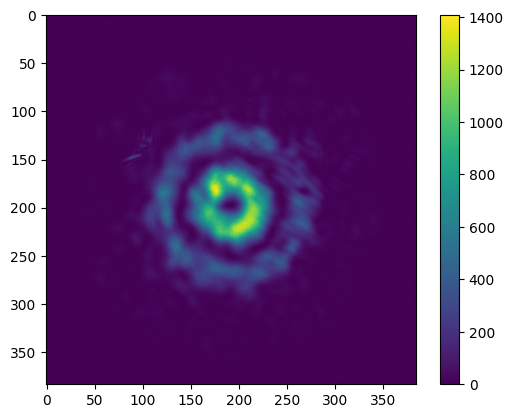

In [101]:
idx = 8
random: bool = True
if random:
    idx = np.random.randint(0, len(CP))

plt.imshow(CP[idx, ...], vmin=0)
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

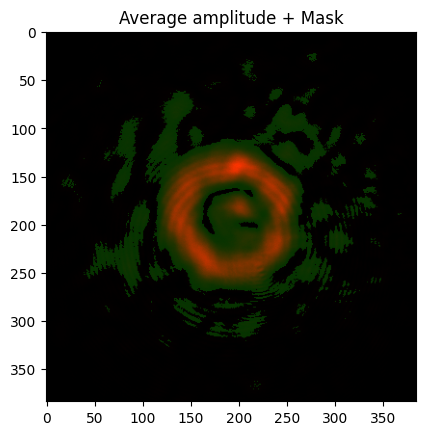

9.96282958984375


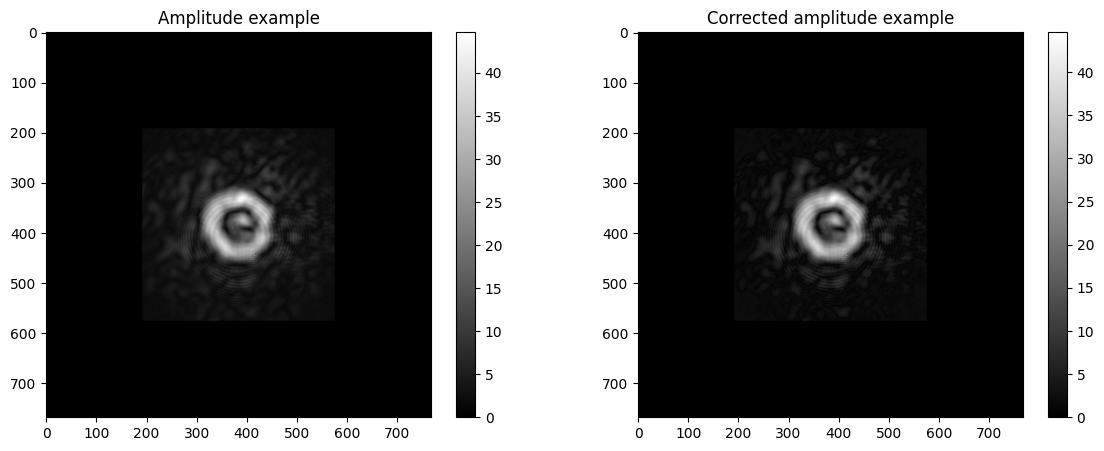

In [102]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.02, plot_result=True, plot_mask=True)
print(noise_corr)

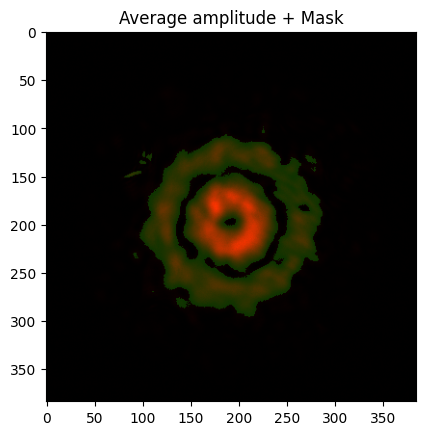

8.356133355034721


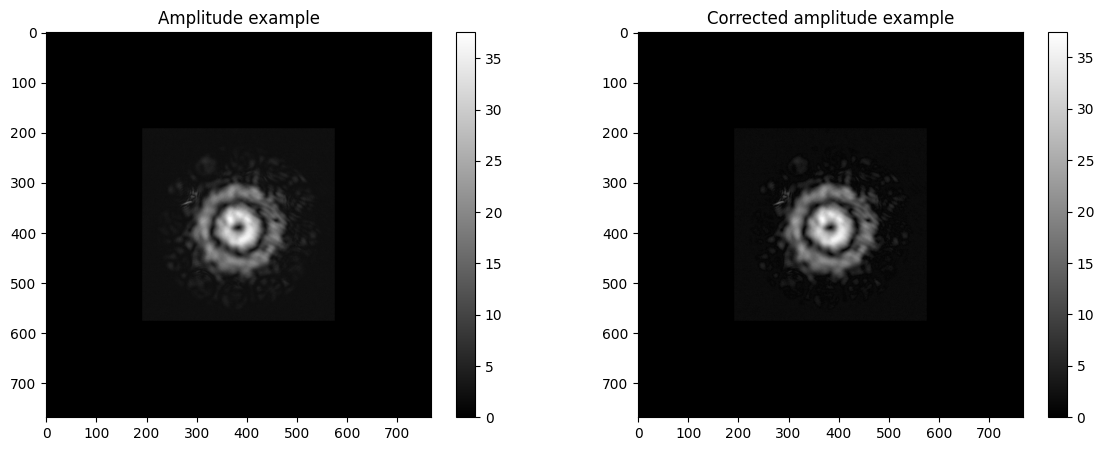

In [103]:
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0,), mask_trsh=0.05, plot_mask=True, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [104]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(-1, -2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(-1, -2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (np.float64(0.0), np.float64(195.41547441927136))
Average centroid CL: (np.float64(0.0), np.float64(190.15590596251985))


### Data preparation

Select data for phase retrieval

294
(294, 294) 495033.6350316934
(294, 294) 720799.344141492


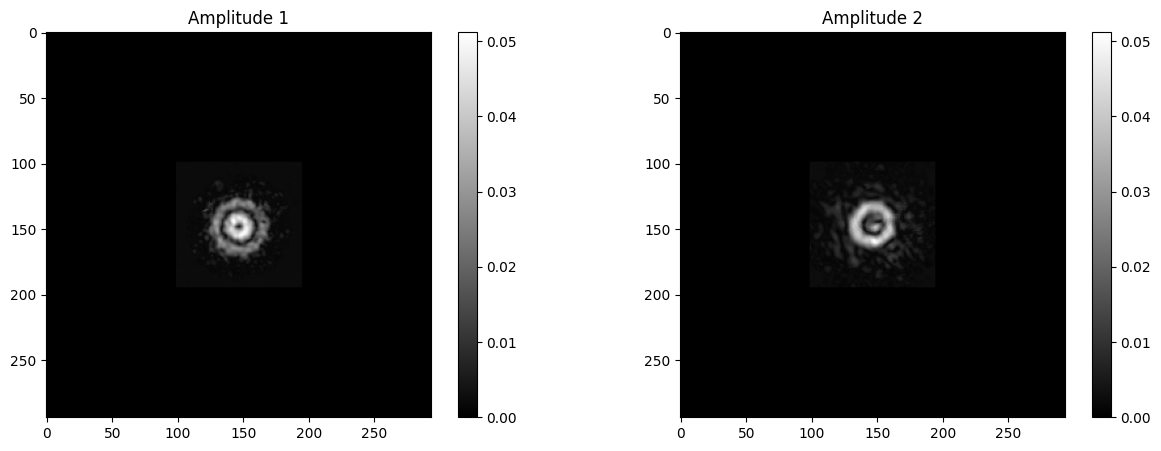

In [105]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 4
bin_cl = 4
N_window = compute_N_win(561.4e-9, 100e-3, bin_cp * 3.45e-6, bin_cl * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - noise_corrCP)) #

# CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - noise_corr)) #
# CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
# ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

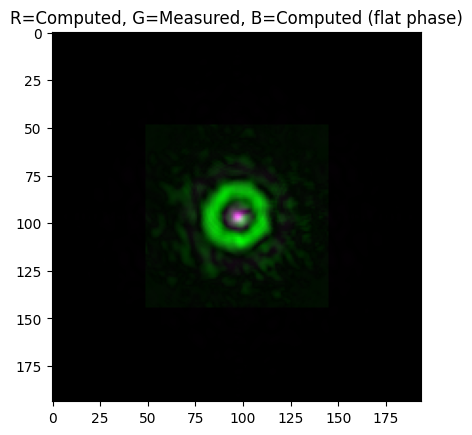

In [106]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = 50

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

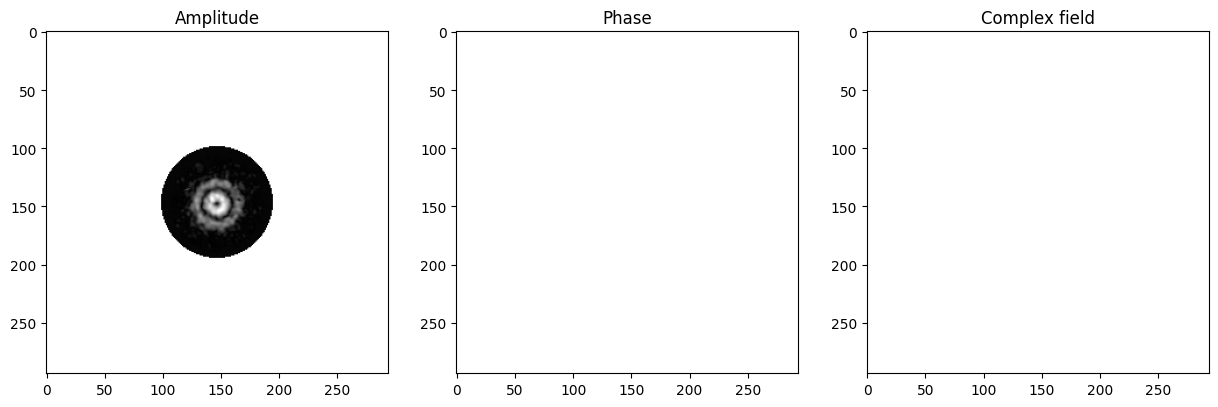

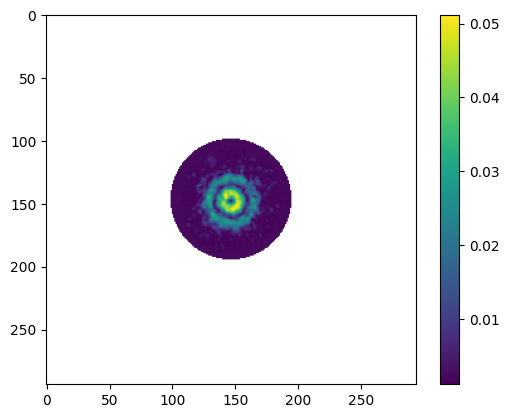

In [107]:
support = spr.supports.threshold_support(field, threshold=0.01)
support = spr.supports.disk_support(field, radius=48, offsets=(0,0))
supported_field = field.copy()
supported_field[np.logical_not(support)] = np.nan
_ = spr.plots.complex_imshow(supported_field)

plt.figure()
plt.imshow(supported_field)
plt.colorbar()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

In [108]:
from matplotlib.colors import hsv_to_rgb

def complex_to_hsv(z, rmin, rmax, hue_start=0, power=1):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    amp = np.power(amp, power)
    ph = np.angle(z, deg=True) + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp - rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = np.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

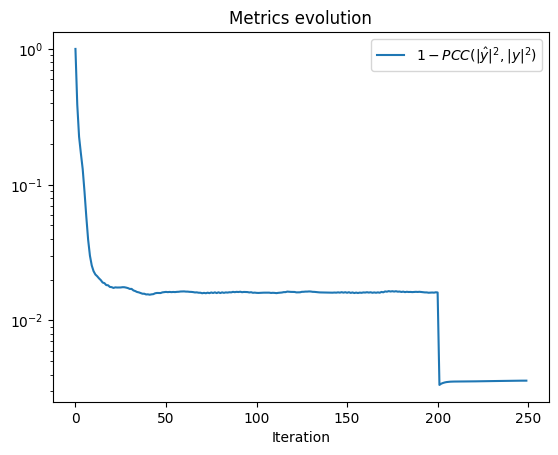

(np.float64(-0.5), np.float64(173.5), np.float64(173.5), np.float64(-0.5))

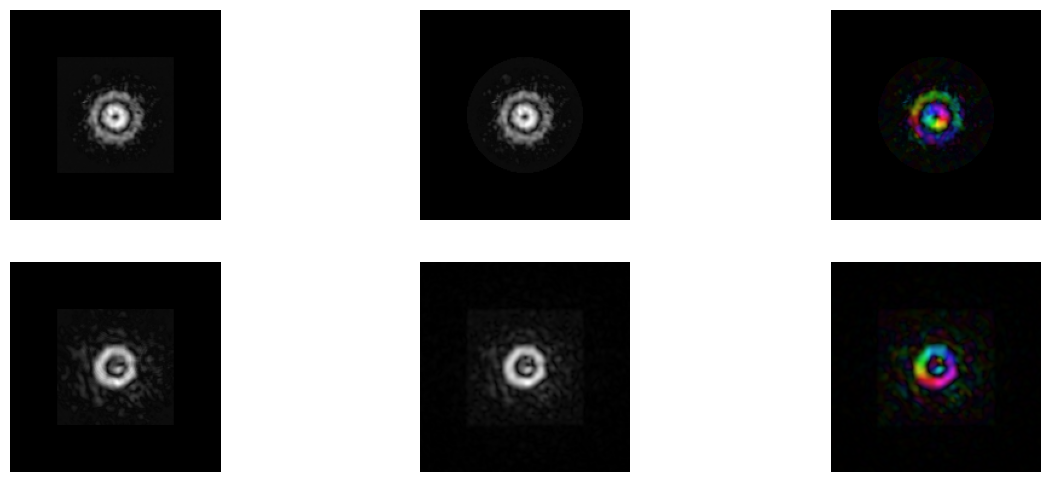

In [109]:
from speckleret.transforms import fourier_transform

results = []

# x, result = spr.retrievalmath.run(
#         magnitudes=(np.abs(field), np.abs(ft)),
#         support=support,
#         init=spr.initializers.flat_phases(magnitude=np.abs(field)),
#         algorithm=spr.retrievalmath.HIO,
#         algorithm_kwargs={'beta': 0.9},
#         max_iter=50,
#         rel_tol=1e-6,
# )
# results.append(result)

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=x,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        init=spr.initializers.random_phases(magnitude=np.abs(field)),
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=200,
        rel_tol=1e-6,
)
results.append(result)

# # x = np.abs(field) * np.exp(1j * np.angle(x))

x, result = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        # init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        init=x,
        algorithm=spr.retrievalmath.ER,
        max_iter=50,
        rel_tol=1e-6,
)
results.append(result)




x_hat = x
# x_hat = np.abs(field) * np.exp(1j * np.angle(x))
# x_hat[np.logical_not(support)] = 0


spr.retrievalmath.report_convergence_results(merge_dicts(results))
plt.show()

y_hat = fourier_transform(x_hat)

win_crop = 60
# _ = spr.plots.complex_imshow(x_hat[win_crop:-win_crop, win_crop:-win_crop], remove_ticks=True, figsize=(12,4))
# plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(field[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(np.abs(x_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(complex_to_hsv(x_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(x_hat))))
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(np.abs(ft[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop]), cmap='gray')
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(complex_to_hsv(y_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(y_hat))))
plt.axis('off')

C:\Users\saucourt\AppData\Local\Temp\ipykernel_26808\2776602964.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
C:\Users\saucourt\AppData\Local\Temp\ipykernel_26808\2776602964.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)


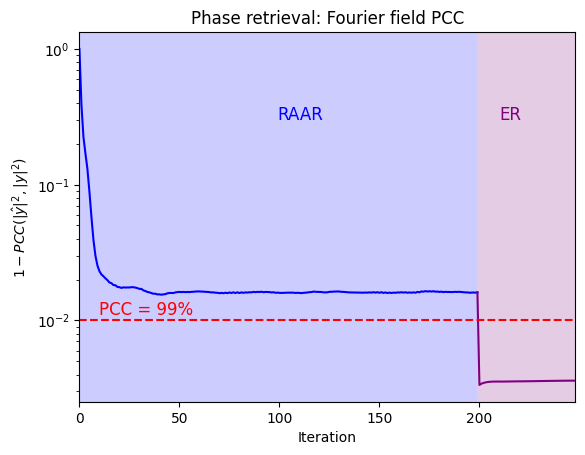

In [110]:
p1 = np.array(results[0]['pearson_fourier_intens'])
t1 = np.arange(0, len(p1))
p2 = np.array(results[1]['pearson_fourier_intens'])
t2 = np.arange(len(p1) -1 , len(p1) + len(p2)  -1)

plt.plot(t1, p1, label='Algorithm = RAAR', color='blue')
plt.plot(t2, p2, label='Algorithm = ER', color='purple')
plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)
plt.axhline(1e-2, color='r', ls='--')
plt.text(10, 1.1e-2, 'PCC = 99%', fontsize=12, color='red')
plt.text(max(t1)//2, 3e-1, 'RAAR', fontsize=12, color='blue')
plt.text(210, 3e-1, 'ER', fontsize=12, color='purple')

plt.xlim([0, len(p1) + len(p2)-2])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$1 - PCC(|\hat{y}|^2, |y|^2)$')
# plt.legend()
plt.title('Phase retrieval: Fourier field PCC')


np.savez(
    file=os.path.join(path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
    field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat, pr_results=results,
)


plt.savefig(os.path.join(path, 'figures', 'PR_speckles_dynamic_' + date + f'_idx={idx}' + '.svg'))
plt.savefig(os.path.join(path, 'figures', 'PR_speckles_dynamic_' + date + f'_idx={idx}' + '.png'))

0.996010508408103


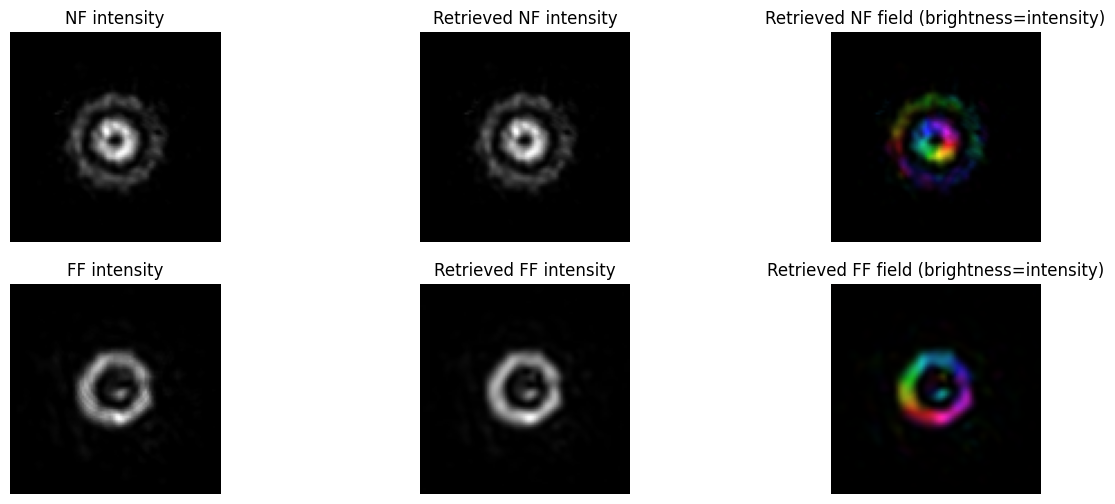

In [111]:
from waveoptics.metrics.numpy import pearson

win_crop = 100



print(pearson(
    x=np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])**2,
    y=np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop])**2,
))

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(field[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.title('NF intensity')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(x_hat[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.title('Retrieved NF intensity')

plt.subplot(2, 3, 3)
xx =np.abs(x_hat)**2  * np.exp(1j * np.angle(x_hat))
plt.title('Retrieved NF field (brightness=intensity)')
# plt.imshow(complex_to_hsv(x_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(x_hat))))

plt.imshow(complex_to_hsv(xx[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(xx))))
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.title('FF intensity')

plt.subplot(2, 3, 5)
plt.imshow(np.abs(y_hat[win_crop:-win_crop, win_crop:-win_crop])**2, cmap='gray')
plt.axis('off')
plt.title('Retrieved FF intensity')


plt.subplot(2, 3, 6)

yy =np.abs(y_hat)**2  * np.exp(1j * np.angle(y_hat))
# plt.imshow(complex_to_hsv(y_hat[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(y_hat))))
plt.imshow(complex_to_hsv(yy[win_crop:-win_crop, win_crop:-win_crop], rmin=0, rmax=np.max(np.abs(yy))))
plt.axis('off')
plt.title('Retrieved FF field (brightness=intensity)')



plt.savefig(os.path.join(path, 'figures', 'PR_speckles_results_' + date + f'_idx={idx}' + '.svg'))
plt.savefig(os.path.join(path, 'figures', 'PR_speckles_results_' + date + f'_idx={idx}' + '.png'))

In [99]:
np.savez(
    file=os.path.join(path, 'PR_speckles_' + date + f'_idx={idx}' + '.npz'),
    field=field, fourier=ft, retrieved_field=x_hat, retrieved_fourier=y_hat, pr_results=results,
)

## Now let's do modal decomposition

In [14]:
import hcmmf

mmf = hcmmf.SiwarHCMMF()
mmf.normalize_modes()

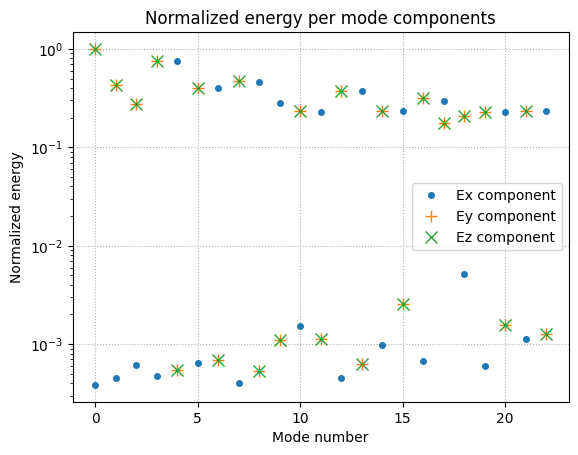

In [15]:
mmf.plot_modes_energies()

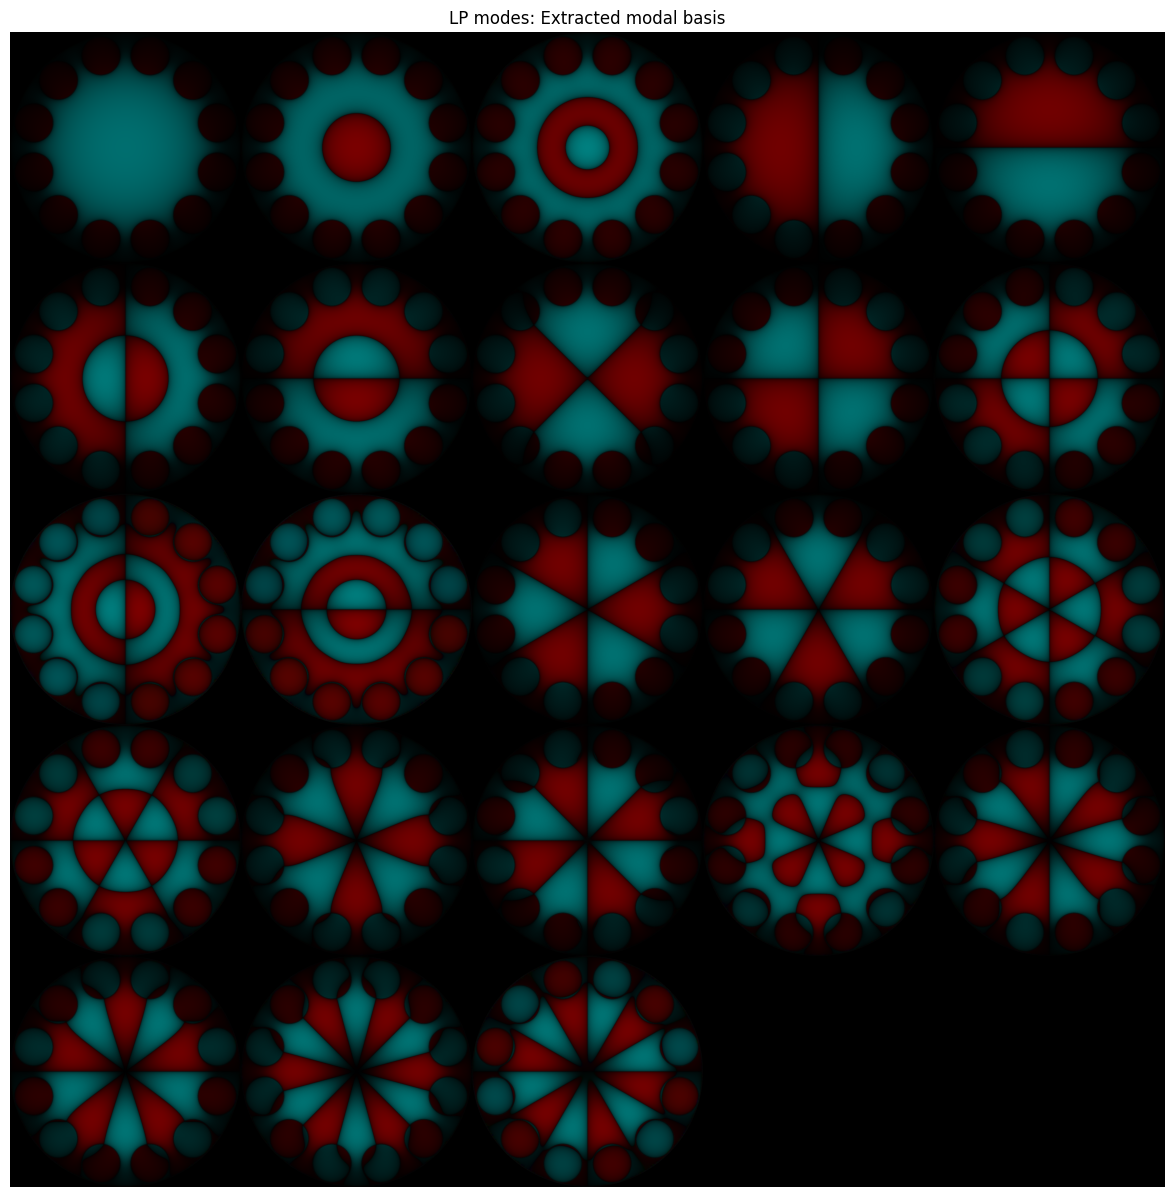

In [16]:
mmf.extract_modal_basis_from_energy(energy_threshold=2e-2, correct_phases=True)
mmf.show_modal_basis(amplitude_power=0.3, complex=True)

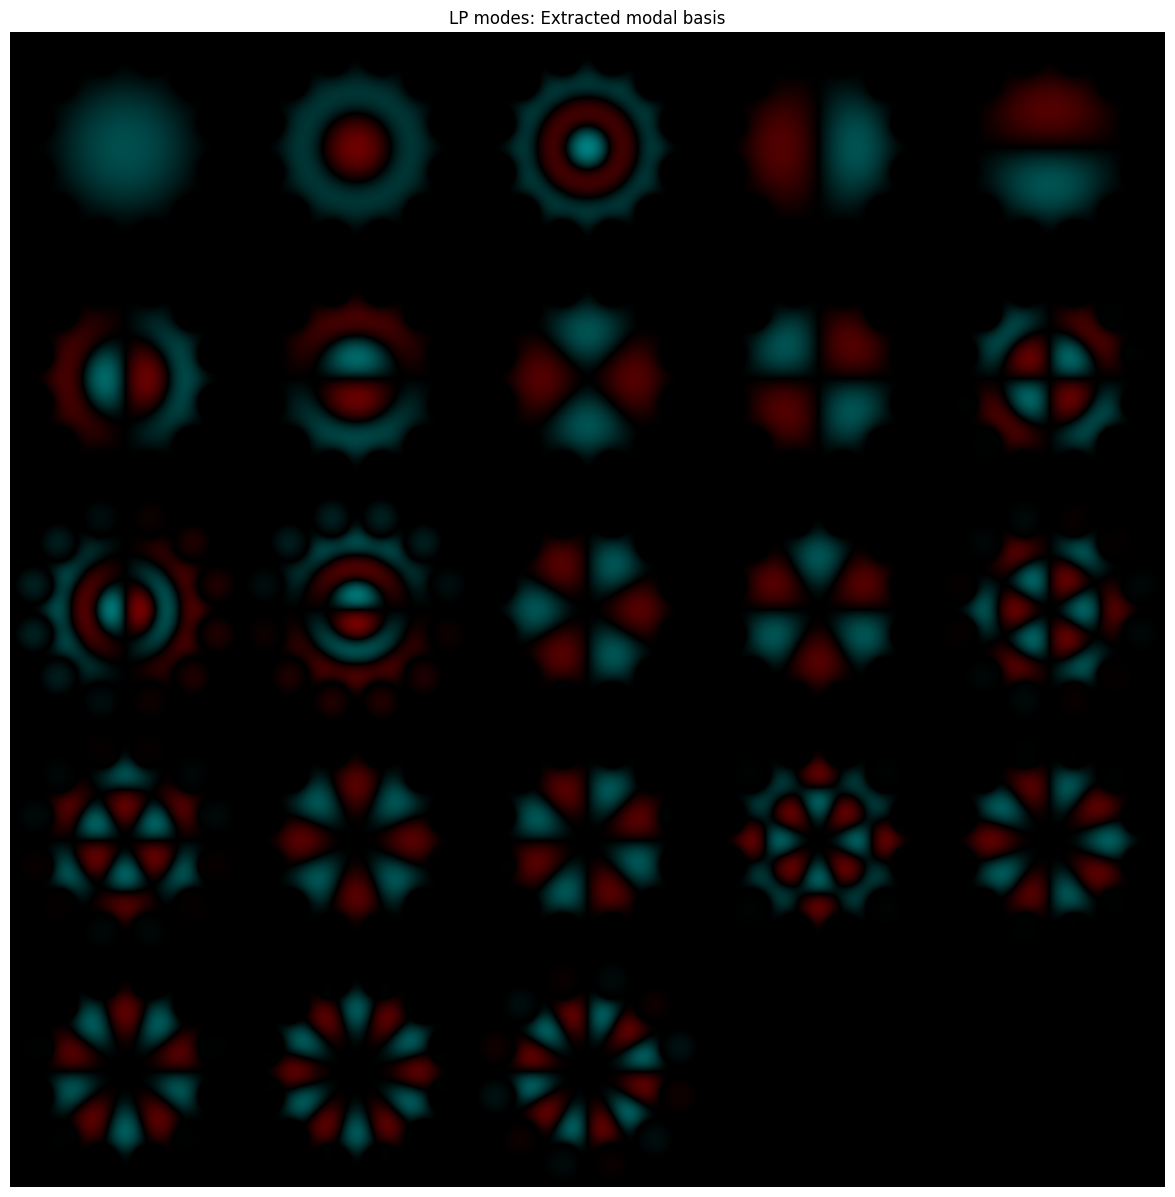

In [161]:
mmf.show_modal_basis(amplitude_power=1, complex=True)

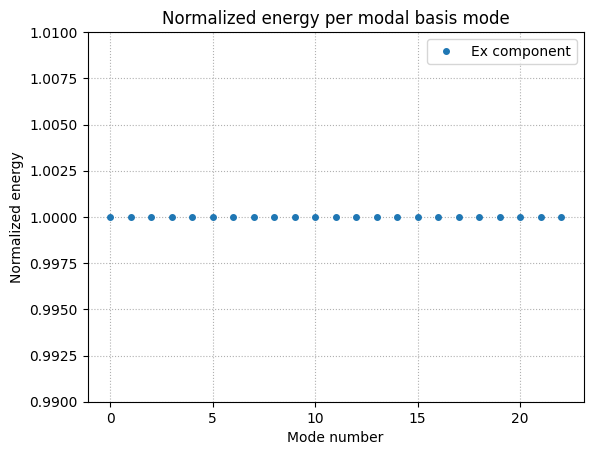

In [17]:
mmf.plot_modal_basis_energies()

Not orthonormal


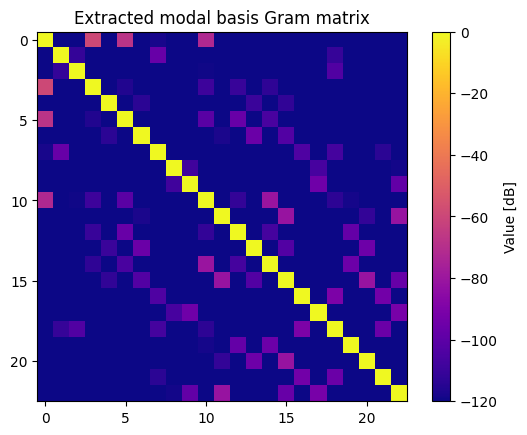

In [18]:
mmf.check_modal_basis_orthogonality(tolerance=1e-3, show_result=True, dynamic_db=120)

In [19]:
modes = np.copy(mmf.modal_basis)

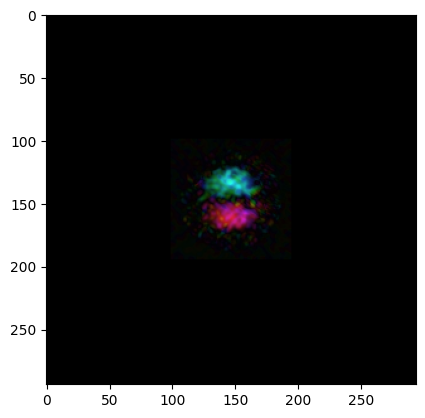

In [20]:
plt.imshow(complex_to_hsv(x_hat, rmin=0, rmax=np.max(np.abs(x_hat))))

In [59]:
from hcmmf.processing import resample_mode
from hcmmf.processing import rotate_complex_image, zoom_complex_image
from hcmmf.integrals import power_overlap_integral

def coeff_from_rotate_and_zoom(field, mode, rotations_deg, zooms):
    intensity_coeffs = np.nan * np.zeros(shape=(len(zooms), len(rotations_deg)))

    for z in range(len(zooms)):
        _mode = zoom_complex_image(mode, zoom_factor=zooms[z])
        _mode /= np.linalg.norm(_mode)

        for r in range(len(rotations_deg)):
            _mode = rotate_complex_image(_mode, degrees=rotations_deg[r])
            _mode /= np.linalg.norm(_mode)
            intensity_coeffs[z, r] = power_overlap_integral(field, _mode)

    best_z_index, best_r_index = np.unravel_index(np.argmax(intensity_coeffs), intensity_coeffs.shape)
    best_zoom = zooms[best_z_index]
    best_rotation_deg = rotations_deg[best_r_index]

    plt.imshow(intensity_coeffs * 100, aspect='auto', extent=[np.min(rotations_deg), np.max(rotations_deg), np.min(zooms), np.max(zooms)])
    plt.xlabel('Rotation [deg]')
    plt.ylabel('Zoom factor')   
    plt.colorbar(label='Energy [%]')
    plt.title(f"Max energy = {np.max(intensity_coeffs) * 100:.1f} %\nBest zoom = {best_zoom:.2f}, best rot = {best_rotation_deg:.1f} deg")


def coeff_from_multiple_defects(field: np.ndarray, mode: np.ndarray, rotations_deg: list[float], zooms: list[float], shifts_v: list[int], shifts_h:  list[int]):
    mode = np.copy(mode)
    intensity_coeffs = np.nan * np.zeros(shape=(len(zooms), len(rotations_deg), len(shifts_v), len(shifts_h)))

    for v in range(len(shifts_v)):
        for h in range(len(shifts_h)):
            _mode = np.roll(np.copy(mode), shift=int(shifts_v[v]), axis=0)
            _mode = np.roll(_mode, shift=int(shifts_h[h]), axis=1)
            _mode /= np.linalg.norm(_mode)

            for z in range(len(zooms)):
                _mode = zoom_complex_image(_mode, zoom_factor=zooms[z])
                _mode /= np.linalg.norm(_mode)

                for r in range(len(rotations_deg)):
                    _mode = rotate_complex_image(_mode, degrees=rotations_deg[r])
                    _mode /= np.linalg.norm(mode)
                    intensity_coeffs[z, r, v, h] = power_overlap_integral(field, _mode)

    best_z_index, best_r_index, best_v_index, best_h_index = np.unravel_index(np.argmax(intensity_coeffs), intensity_coeffs.shape)
    best_zoom = zooms[best_z_index]
    best_rotation_deg = rotations_deg[best_r_index]
    best_v_shift = int(shifts_v[best_v_index])
    best_h_shift = int(shifts_h[best_h_index])

    print(f"Max coupled energy: {np.max(intensity_coeffs) * 100:.1f} %")
    print(f"    - Best zoom factor = {best_zoom:.2f}")
    print(f"    - Best rotation = {best_rotation_deg:.1f} deg")
    print(f"    - Best vertical shift = {best_v_shift} px")
    print(f"    - Best horizontal shift = {best_h_shift} px")


In [147]:
loading_path = r'C:\Users\saucourt\Downloads\siwar_fields'
loaded_data = np.load(os.path.join(loading_path, 'PR_shaping_frames_20250612-153737.npz'))
retrieved_field = loaded_data['retrieved_field']

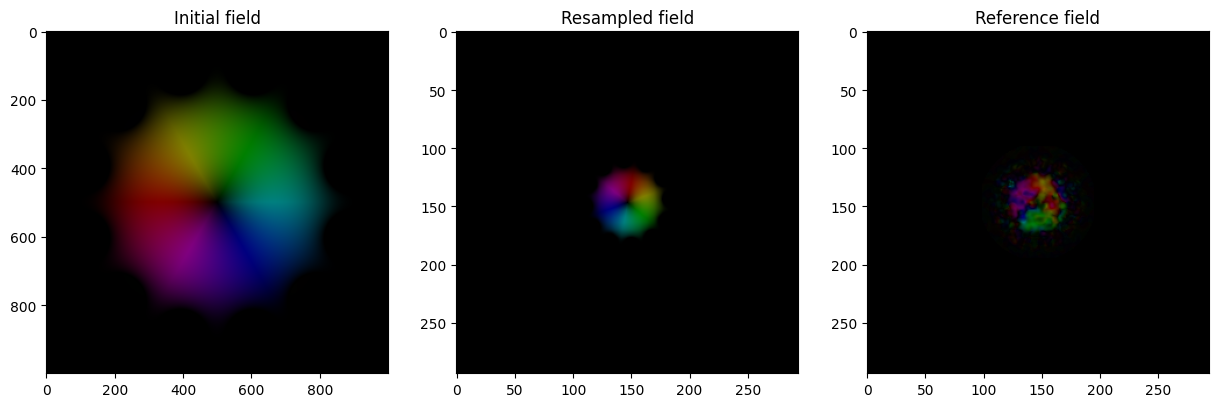

Max coupled energy: 52.9 %
    - Best zoom factor = 0.85
    - Best rotation = -23.8 deg
    - Best vertical shift = 4 px
    - Best horizontal shift = 4 px


In [160]:
from waveoptics.plots.plots import complex_to_hsv

mode = resample_mode(modes[3] + 1j * modes[4], ref_mode=retrieved_field, normalize_energy=True, plot_result=True)
mode = rotate_complex_image(mode, degrees=-100)
mode /= np.linalg.norm(mode)

plt.subplot(1, 3, 2)
plt.imshow(complex_to_hsv(mode, rmin=0, rmax=np.max(np.abs(mode))))
plt.title('Resampled field')
plt.show()



rots = np.linspace(-30, 30, 30)
# rots = np.linspace(35, 55, 15)
zooms = np.linspace(0.85, 1.1, 11)
v_shifts = np.arange(-5, 5, 1)
h_shifts = np.arange(-5, 5, 1)

coeff_from_multiple_defects(retrieved_field, mode, rotations_deg=rots, zooms=zooms, shifts_v=v_shifts, shifts_h=h_shifts)